In [1]:
import os
import pickle
import numpy as np
from scipy.special import expit
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from utils_models import *
from funcs_model_simulation import *
from funcs_learning_curves import *

In [2]:
datasetName = 'takahashi2016roesch2009burton2018Valid'
dataValid = pd.read_csv('data/' + datasetName + '.csv')
ratList = dataValid['rat'].unique()

In [3]:
models = ['sixState_full', 'fourState_full', 'hybridValue_full', 'hybridLearning_full']

In [4]:
dir_simu = 'model_simulation/'

## Run simulation / Load simulated data

Running the simulation takes a long time. For easy reproduction of figures in the paper, we have saved the aggregated results, and you can load them directly by setting `run_simulation = False`.

In [5]:
def get_simulated_data(varName, modelName, w4=None, NSessions=10000, run_simulation=False):
    
    fileName = dir_simu + modelName + '_' + datasetName + '_groupMean' + (('_w4' + str(w4)) if w4 is not None else '') + '_NSessions' + str(NSessions) + '_NTrials' + str(NTrials) + '_' + varName + '.pickle'
    
    if varName == 'curveData':
        curveData = None
    
    if run_simulation:
        # set parameter values
        params = get_params(datasetName, modelName)
        if w4 is not None:
            params[1] = w4
        # run simulation
        dataSimu = model_simulate(modelName, params, NSessions, NTrials)
        if varName == 'avgR':
            # calculate average reward
            value = dataSimu['rewardAmount'].mean()
        elif varName == 'curveData':
            # prepare data for plotting learning curve
            value = plotLearningCurve(dataSimu, N=10, ifReturnCurveData=True)
        # save results
        pickle.dump(value, open(fileName, 'wb'))
    else:
        # load results
        value = pickle.load(open(fileName, 'rb'))
        
    return value

## Average reward

In [6]:
# simulation parameters
NSessions = 100000
NTrials = 57
w4List = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

In [7]:
run_simulation = False

avgR = dict.fromkeys(['rat'+str(rat) for rat in ratList] + models + ['w4'+str(w4) for w4 in w4List])

# all models
for modelName in models:
    avgR[modelName] = get_simulated_data('avgR', modelName, None, NSessions, run_simulation)
            
# hybrid-value model: w4 from 0 to 1
modelName = 'hybridValue_full'
for w4 in w4List:
    avgR['w4'+str(w4)] = get_simulated_data('avgR', modelName, w4, NSessions, run_simulation)

# animals
for rat in ratList:
    avgR['rat'+str(rat)] = dataValid.loc[dataValid['rat'] == rat, 'rewardAmount'].mean()

### Load fitted $w_4$ value for hybrid-value model

In [8]:
allSamples = pd.read_csv('model_fits/' + datasetName + '_hybridValue_full_allSamples.csv')
w4_fit = phi_approx(allSamples.loc[allSamples['warmup']==0, 'mu_pr[2]'].values.mean())

### Plot

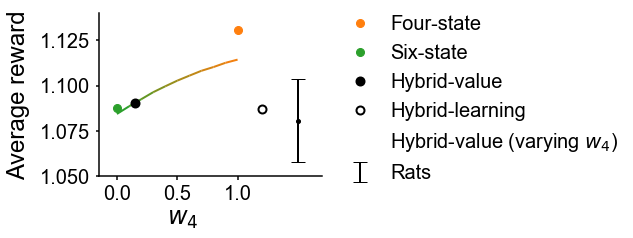

In [9]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
plt.rcParams.update({'font.family': 'arial'})
lineWidth = 2
fontsize = 24
labelsize = 20
ylim=[1.05, 1.14]

fig, ax = plt.subplots(figsize=(4,3))

# simulation
ax.plot(1, avgR['fourState_full'], 'o', color='C1', linewidth=lineWidth, markersize=8, label='Four-state')
ax.plot(0, avgR['sixState_full'], 'o', color='C2', linewidth=lineWidth, markersize=8, label='Six-state')
ax.plot(w4_fit, avgR['hybridValue_full'], 'o', color='k', linewidth=lineWidth, markersize=8, markeredgewidth=2, label='Hybrid-value')
ax.plot(1.2, avgR['hybridLearning_full'], 'o', color='k', linewidth=lineWidth, markersize=8, fillstyle='none', markeredgewidth=2, label='Hybrid-learning')

from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.collections import LineCollection
N = 256
vals = np.ones((N, 4))
vals[:, 0] = np.linspace(44/256, 255/256, N)
vals[:, 1] = np.linspace(160/256, 127/256, N)
vals[:, 2] = np.linspace(44/256, 14/256, N)
cmap = ListedColormap(vals)
x = np.array(w4List)
y = np.array([avgR['w4'+str(w4)] for w4 in w4List])
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
norm = plt.Normalize(np.min(y), np.max(y))
lc = LineCollection(segments, cmap=cmap, norm=norm, color='w', label='Hybrid-value (varying $w_4$)')
lc.set_array(y)
lc.set_linewidth(lineWidth)
line = ax.add_collection(lc)

# animals
avgR_rat = np.array([avgR['rat'+str(rat)] for rat in ratList])
ax.errorbar(x=1.5, y=np.mean(avgR_rat), yerr=np.std(avgR_rat)/np.sqrt(len(ratList)), linestyle='', color='k', capsize=7, linewidth=lineWidth, label='Rats')
ax.plot(1.5, np.mean(avgR_rat), '.', color='k', markersize=8)

ax.set_xlabel('$w_4$         ', fontsize=fontsize)
ax.set_ylabel('Average reward', fontsize=fontsize, labelpad=10)
ax.tick_params(axis='both', width=1.5, pad=5, direction='out', labelsize=labelsize)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.set(xlim=[-0.15,1.7], ylim=ylim)
ax.set(xticks=[0,0.5,1])

ax.legend(frameon=False, fontsize=labelsize, handletextpad=0.5, bbox_to_anchor=(1, 1.1))

plt.show()

## Learning curves

In [10]:
# simulation parameters
NSessions = 10000
NTrials = 57

In [11]:
run_simulation = False

curveData = dict.fromkeys(['w4'+str(w4) for w4 in w4List])
            
# hybrid-value model: w4 = 0 and 1
modelName = 'hybridValue_full'
for w4 in [0,1]:
    curveData['w4'+str(w4)] = get_simulated_data('curveData', modelName, w4, NSessions, run_simulation)

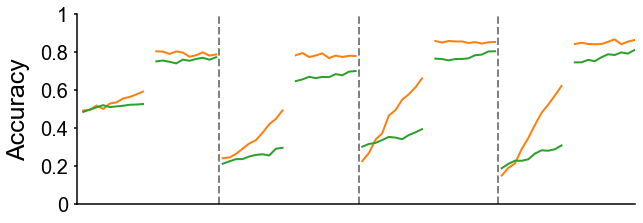

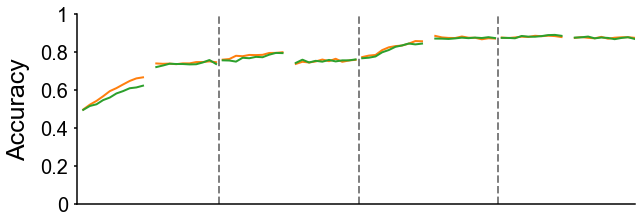

In [12]:
from utils_dataset import n_blocks
import pickle

model = 'hybridValue_full'
modelLabels = ['Six-state', 'Four-state']

# plot setting
N = 10
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
plt.rcParams.update({'font.family': 'arial'})
lineWidth = 2
    
for trialType in ['free', 'forced']:
    fig, ax = plt.subplots(figsize=(10,3.5))

    for w4 in [1, 0]:
        trialIndices = curveData['w4'+str(w4)][trialType, 'x']
        y = curveData['w4'+str(w4)][trialType, 'y']
        err = curveData['w4'+str(w4)][trialType, 'err']
        ax.plot(trialIndices, y, linewidth=lineWidth, color='C'+str(2-w4), label=modelLabels[w4], lineWidth=lineWidth)

    for blockChange in np.array([N*2+1, N*4+2, N*6+3])+0.5:
        ax.axvline(x=blockChange, linestyle='--', color='gray', linewidth=lineWidth)
    
    ax.set_ylim([0, 1])
    ax.set_xlim([0, N*8+4])
    ax.set_xlabel('Trial')
    ax.set_ylabel('Accuracy')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticklabels('')
    ax.tick_params(axis='x', length=0)
    ax.set_xlabel('')
    ax.tick_params(axis='y', width=1.5, pad=5, direction='out')
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=20)
    ax.set_ylabel('Accuracy', fontsize=25)
    ax.yaxis.labelpad = 10
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)